## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [1]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [2]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231138"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [3]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': [], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu22.04', 'packages': [], 'bastion': False} 
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

In [4]:
print(username)

sk10945_nyu_edu


### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [5]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

In [6]:
public_net = os_conn.network.find_network("public_net_" + username)
public_net_id = public_net.get("id")

In [7]:
public_net = os_conn.network.create_network(name="public_net_" + username)

Next, we will prepare the “experiment” networks -

In [8]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [9]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [10]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [11]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': '3dba6152-fca5-4cdf-bf3d-af134f5aa8a0',
 'tenant_id': '13a1ac1ce275484caedc3394339486a1',
 'subnet_id': '1fef5952-f6a8-4842-bc42-347776b66fa9',
 'subnet_ids': ['1fef5952-f6a8-4842-bc42-347776b66fa9'],
 'port_id': '96ab8734-d9eb-449a-ba3e-689be5bcf935',
 'id': 'a91b5b22-bb9d-47fa-857f-5e1f78fadfc2'}

In [21]:
print(server_ids)

['6cf83372-4525-4ea5-96df-7f006d655a9c', 'e1279bd7-0e69-434c-8097-4be22a1fe734', '91237d82-9255-42a9-9ea2-cb5575d32531']


In [13]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = []
for i, n in enumerate(node_conf):
    if 'bastion' in n and n['bastion']:
        ip = chi.server.associate_floating_ip(server_ids[i])
        server_ips.append(ip)

In [19]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [22]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

In [4]:
server_ips= []
server_ips.append('129.114.26.159')
print(server_ips)

['129.114.26.159']


The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [24]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [25]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    # Add Flyte ports
    remote.run(f"sudo firewall-cmd --zone=public --add-port=8088/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=8089/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=9000/tcp")
    # Reload firewall
    remote.run(f"sudo firewall-cmd --reload")
    time.sleep(3)

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.26.159: b'7a9630670b92096ada990e11cfbf9930'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'7a9630670b92096ada990e11cfbf9930'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'08f4740ff8117682c75e7c3207b83101'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'5a55552c836ee3e690544db5294e934b'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success
success
success
success
success


In [ ]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

In [27]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

In [28]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 8088"):
    os_conn.create_security_group("Allow HTTP 8088", "Enable HTTP traffic on TCP port 8088")
    os_conn.create_security_group_rule("Allow HTTP 8088", port_range_min=8088, port_range_max=8088, protocol='tcp', remote_ip_prefix='0.0.0.0/0')
    
# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 8088").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [29]:
!pip install networkx

In [30]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

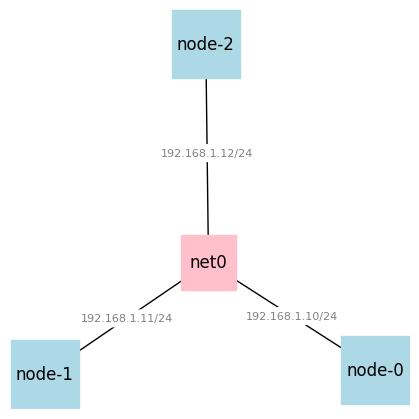

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [32]:

remote = chi.ssh.Remote(server_ips[0])

In [ ]:
# install Python libraries required for Kubespray
remote.run("python3 -m venv myenv")
remote.run("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
remote.run("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

In [34]:
# copy config files to correct locations
remote.run("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.run("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.run("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.run("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.run("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

Cloning into 'k8s'...


<Result cmd='cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml' exited=0>

In [35]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
#remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")
remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")

DEBUG: Adding group all
DEBUG: Adding group kube_control_plane
DEBUG: Adding group kube_node
DEBUG: Adding group etcd
DEBUG: Adding group k8s_cluster
DEBUG: Adding group calico_rr
DEBUG: adding host node-0 to group all
DEBUG: adding host node-1 to group all
DEBUG: adding host node-2 to group all
DEBUG: adding host node-0 to group etcd
DEBUG: adding host node-1 to group etcd
DEBUG: adding host node-2 to group etcd
DEBUG: adding host node-0 to group kube_control_plane
DEBUG: adding host node-1 to group kube_control_plane
DEBUG: adding host node-0 to group kube_node
DEBUG: adding host node-1 to group kube_node
DEBUG: adding host node-2 to group kube_node


<Result cmd='source myenv/bin/activate; declare -a IPS=(192.168.1.10 192.168.1.11 192.168.1.12);cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}' exited=0>

In [36]:
# make sure "controller" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQDVki2HKQcDzVkw71W/abA5hsdWlJrqLdh/XWaydCCdVCKaDczPQnvOPfP/JgBHQmBxh/vZA3D48Uc8mzO8T10jOqX8oTKLENfPFgvW/kkl1ed8sSc6KcAs4PYjAFWicuyOKHmPHQwowtm2dsZ8ULucvpQXh4hbZucNi+KzTmXYsF2u/ZQjNgp98gdxEqnEJhQSJv99AsUstEzFnn8yJOILEFhe98a+R+8NuvMXxzDployQo3VMhocKUjX59wPrp3UyXXKW0QzpTMLVEzUvc+LvYxCi2DEpE/NRZ7glqC3/QJPSJFLIbi6I+3EmbggbpV0Am1Elbi5rzUuwcfWBex8XZq5Wf10PbW9u9CN9bPaHjgVs6N3Zbb1pvlj5UGetMoUdZRJf3yFwTVpxX6t/HaytoXlantlp9mRu0ZMlFXSzZTS2051wehCaZrdBuP/fBt0HjzrJpqPpxB1tmlyz3mLSqADsEQWfWngin36hh095iTH6HgUO7L8y7o0gXrUTIrUkCzTsb3fwOvNvfV2Wruz5Fh3MQNbuTNiI0yg302GPFIBsvyTbSReXSjrvvDe5NdwmV4dCATEueeveQLOxkrwQQUBMtQF6bW0rM8DimrARE0b+Y93OnNN+r6pdTgXWYekt/ij/zVGxK3WnpyOK1xXtnUqI5GC0d0oCChluxs0lXQ== cc@node-0-sk10945-nyu-edu


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'7a9630670b92096ada990e11cfbf9930'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'08f4740ff8117682c75e7c3207b83101'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'5a55552c836ee3e690544db5294e934b'
  warnings.warn(


The following cell will actually build the cluster. It will take a long time, and you may see many warnings in the output - that’s OK. The instructions below explain how to tell whether it was successful or not.

The output will be very long, so it will be truncated by default. When you see

    Output of this cell has been trimmed on the initial display.
    Displaying the first 50 top outputs.
    Click on this message to get the complete output.

at the end, click in order to see the rest of the output.

When the process is finished, you will see a “PLAY RECAP” in the output (near the end):

    PLAY RECAP *********************************************************************
    localhost                  : ok=3    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
    node-0                     : ok=752  changed=149  unreachable=0    failed=0    skipped=1276 rescued=0    ignored=8   
    node-1                     : ok=652  changed=136  unreachable=0    failed=0    skipped=1124 rescued=0    ignored=3   
    node-2                     : ok=535  changed=112  unreachable=0    failed=0    skipped=797  rescued=0    ignored=2   

Make sure that each node shows `failed=0`. If not, you should re-run the cell to re-try the failed parts.

In [ ]:
# build the cluster
remote.run("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")

In [38]:
# allow kubectl access for non-root user
remote.run("sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube")

<Result cmd='sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube' exited=0>

In [39]:
# check installation
remote.run("kubectl get nodes")

NAME     STATUS   ROLES           AGE     VERSION
node-0   Ready    control-plane   4m46s   v1.26.5
node-1   Ready    control-plane   4m26s   v1.26.5
node-2   Ready    <none>          3m14s   v1.26.5


<Result cmd='kubectl get nodes' exited=0>

### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [40]:
# add the user to the "docker" group on all hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [41]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote = chi.ssh.Remote(server_ips[0])
remote.run("docker run -d -p 5000:5000 --restart always --name registry registry:2")

Unable to find image 'registry:2' locally
2: Pulling from library/registry
5fa62e1bbddf: Pulling fs layer
512fd48e9ac5: Pulling fs layer
669420efbe7e: Pulling fs layer
afcf3903ce8c: Pulling fs layer
ae1e60cf899f: Pulling fs layer
afcf3903ce8c: Waiting
ae1e60cf899f: Waiting
512fd48e9ac5: Verifying Checksum
512fd48e9ac5: Download complete
5fa62e1bbddf: Verifying Checksum
5fa62e1bbddf: Download complete
669420efbe7e: Verifying Checksum
669420efbe7e: Download complete
afcf3903ce8c: Verifying Checksum
afcf3903ce8c: Download complete
ae1e60cf899f: Verifying Checksum
ae1e60cf899f: Download complete
5fa62e1bbddf: Pull complete
512fd48e9ac5: Pull complete
669420efbe7e: Pull complete
afcf3903ce8c: Pull complete
ae1e60cf899f: Pull complete
Digest: sha256:26f7266535a3a1dae81e137ba4935c59d96e7bb4b700f64e4af8959ca5ab0419
Status: Downloaded newer image for registry:2


69f38874a7380dbc59e192749f608d8ee11e61b359d375db7a1175ecb2ead060


<Result cmd='docker run -d -p 5000:5000 --restart always --name registry registry:2' exited=0>

In [42]:
# set up docker configuration on all the hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    remote_worker.run("sudo service docker restart")


--2025-01-08 10:31:37--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘/etc/docker/daemon.json’

     0K                                                       100%  945K=0s

2025-01-08 10:31:37 (945 KB/s) - ‘/etc/docker/daemon.json’ saved [65/65]

--2025-01-08 10:31:49--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Sav

In [43]:
# check configuration
remote.run("docker run hello-world")

Unable to find image 'hello-world:latest' locally
latest: Pulling from library/hello-world
c1ec31eb5944: Pulling fs layer
c1ec31eb5944: Verifying Checksum
c1ec31eb5944: Download complete
c1ec31eb5944: Pull complete
Digest: sha256:5b3cc85e16e3058003c13b7821318369dad01dac3dbb877aac3c28182255c724
Status: Downloaded newer image for hello-world:latest



Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



<Result cmd='docker run hello-world' exited=0>

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [5]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.26.159


In [5]:

remote = chi.ssh.Remote(server_ips[0])

Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)

## Flyte Deployment v2

In [51]:
#installing helm
remote.run("curl https://raw.githubusercontent.com/helm/helm/main/scripts/get-helm-3 | bash")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 11903  100 11903    0     0  74921      0 --:--:-- --:--:-- --:--:-- 75335


Verifying checksum... Done.
Preparing to install helm into /usr/local/bin
helm installed into /usr/local/bin/helm


<Result cmd='curl https://raw.githubusercontent.com/helm/helm/main/scripts/get-helm-3 | bash' exited=0>

### Creating flyte namespace and storage class to enable dynamic provisioning 

In [52]:
remote.run("kubectl create namespace flyte")
remote.run("kubectl get storageclass -n flyte")

namespace/flyte created


No resources found


<Result cmd='kubectl get storageclass -n flyte' exited=0>

In [53]:
remote.run("helm repo add rimusz https://charts.rimusz.net")
remote.run("helm repo update")
remote.run("helm upgrade --install hostpath-provisioner --namespace flyte rimusz/hostpath-provisioner")
remote.run("kubectl get storageclass -n flyte")

"rimusz" has been added to your repositories
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "rimusz" chart repository
Update Complete. ⎈Happy Helming!⎈
Release "hostpath-provisioner" does not exist. Installing it now.
NAME: hostpath-provisioner
LAST DEPLOYED: Wed Jan  8 10:34:01 2025
NAMESPACE: flyte
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
The Hostpath Provisioner service has now been installed.

A storage class named 'hostpath' has now been created
and is available to provision dynamic volumes.

You can use this storageclass by creating a `PersistentVolumeClaim` with the
correct storageClassName attribute. For example:

    ---
    kind: PersistentVolumeClaim
    apiVersion: v1
    metadata:
      name: test-dynamic-volume-claim
    spec:
      storageClassName: "hostpath"
      accessModes:
        - ReadWriteOnce
      resources:
        requests:
          storage: 100Mi
NAME                 PROVISIONER   RECL

<Result cmd='kubectl get storageclass -n flyte' exited=0>

In [125]:
# uncomment if you would like to delete the storage class created above
#remote.run("kubectl delete storageclass hostpath -n flyte")

storageclass.storage.k8s.io "hostpath" deleted


<Result cmd='kubectl delete storageclass hostpath -n flyte' exited=0>

In [54]:
# Downloading the needed dependencies for flyte into the master node
remote.run("curl -sl https://raw.githubusercontent.com/ShaktidharK1997/flyte-artifact/refs/heads/main/onprem-flyte-dependencies.yaml > onprem-flyte-dependencies.yaml")


<Result cmd='curl -sl https://raw.githubusercontent.com/ShaktidharK1997/flyte-artifact/refs/heads/main/onprem-flyte-dependencies.yaml > onprem-flyte-dependencies.yaml' exited=0>

In [55]:
#running the dependencies yaml in master node 
remote.run("kubectl apply -f onprem-flyte-dependencies.yaml")

namespace/flyte configured
persistentvolumeclaim/postgresql-pvc created
persistentvolumeclaim/minio-pvc created
service/postgres created
deployment.apps/postgres created
deployment.apps/minio created
service/minio created


<Result cmd='kubectl apply -f onprem-flyte-dependencies.yaml' exited=0>

In [59]:
#checking pod status ( Object store MinIO and PgSQL database containers must be created)
remote.run("kubectl get pods -n flyte")

NAME                                   READY   STATUS    RESTARTS   AGE
hostpath-provisioner-5bb665c64-b76w6   1/1     Running   0          41s
minio-6dfd8b7d76-kffd9                 1/1     Running   0          29s
postgres-5cd768484f-k4m6l              1/1     Running   0          29s


<Result cmd='kubectl get pods -n flyte' exited=0>

In [126]:
#uncomment if you would like to delete the created dependencies
#remote.run("kubectl delete -f onprem-flyte-dependencies.yaml")

namespace "flyte" deleted
persistentvolumeclaim "postgresql-pvc" deleted
persistentvolumeclaim "minio-pvc" deleted
service "postgres" deleted
deployment.apps "postgres" deleted
deployment.apps "minio" deleted
service "minio" deleted


<Result cmd='kubectl delete -f onprem-flyte-dependencies.yaml' exited=0>

In [60]:
#add flyte through helm repo
remote.run("helm repo add flyteorg https://flyteorg.github.io/flyte")

"flyteorg" has been added to your repositories


<Result cmd='helm repo add flyteorg https://flyteorg.github.io/flyte' exited=0>

In [61]:
remote.run("mkdir -p ~/flyte-config")

#Creating local secret yaml for db password
remote.run("""cat <<EOF > ~/flyte-config/local-secret.yaml      
apiVersion: v1
kind: Secret
metadata:
  name: flyte-binary-inline-config-secret
  namespace: flyte
type: Opaque
stringData:
  202-database-secrets.yaml: |
    database:
      postgres:
        password: "postgres" 
EOF
""")

#Applying local secret

remote.run("kubectl create -f ~/flyte-config/local-secret.yaml")


secret/flyte-binary-inline-config-secret created


<Result cmd='kubectl create -f ~/flyte-config/local-secret.yaml' exited=0>

In [168]:
#uncomment to delete k8s local secret 
#remote.run("kubectl delete -f ~/flyte-config/local-secret.yaml")

secret "flyte-binary-inline-config-secret" deleted


<Result cmd='kubectl delete -f ~/flyte-config/local-secret.yaml' exited=0>

In [62]:
#Installing flyte binary in K8s
remote.run("curl -sL https://raw.githubusercontent.com/davidmirror-ops/flyte-the-hard-way/main/docs/on-premises/single-node/manifests/onprem-flyte-binary-values.yaml > onprem-flyte-binary-values.yaml")

remote.run("helm install flyte-binary flyteorg/flyte-binary  --values onprem-flyte-binary-values.yaml -n flyte")


NAME: flyte-binary
LAST DEPLOYED: Wed Jan  8 10:34:57 2025
NAMESPACE: flyte
STATUS: deployed
REVISION: 1
TEST SUITE: None


<Result cmd='helm install flyte-binary flyteorg/flyte-binary  --values onprem-flyte-binary-values.yaml -n flyte' exited=0>

In [64]:
remote.run("kubectl get pods -n flyte")

NAME                                   READY   STATUS    RESTARTS   AGE
flyte-binary-658fc8b875-b9bwx          0/1     Running   0          25s
hostpath-provisioner-5bb665c64-b76w6   1/1     Running   0          82s
minio-6dfd8b7d76-kffd9                 1/1     Running   0          70s
postgres-5cd768484f-k4m6l              1/1     Running   0          70s


<Result cmd='kubectl get pods -n flyte' exited=0>

In [15]:
#uncomment to uninstall flyte binary
#remote.run("helm uninstall flyte-binary -n flyte")

release "flyte-binary" uninstalled


<Result cmd='helm uninstall flyte-binary -n flyte' exited=0>

## Configuring to connect to installed Flyte

In [65]:
# Installing and configuring flytectl
remote.run("curl -sL https://ctl.flyte.org/install | sudo bash -s -- -b /usr/local/bin")
remote.run("flytectl config init")


flyteorg/flyte info checking GitHub for latest tag
flyteorg/flyte info found version: flytectl/v0.9.4 for flytectl/v0.9.4/Linux/x86_64
flyteorg/flyte info installed /usr/local/bin/flytectl
time="2025-01-08T10:35:31Z" level=info msg="[0] Couldn't find a config file []. Relying on env vars and pflags."


Init flytectl config file at [/home/cc/.flyte/config.yaml]

<Result cmd='flytectl config init' exited=0>

In [66]:
#Need to change content of config file
config_content = """admin:
  endpoint: localhost:8089
  authType: Pkce
  insecure: true
logger:
  show-source: true
  level: 6"""

remote.run(f"""cat << 'EOF' > $HOME/.flyte/config.yaml
{config_content}
EOF""")

<Result cmd="cat << 'EOF' > $HOME/.flyte/config.yaml\nadmin:\n  endpoint: localhost:8089\n  authType: Pkce\n  insecure: true\nlogger:\n  show-source: true\n  level: 6\nEOF" exited=0>

In [67]:
#Creating DNS Service for minio yaml 
remote.run("""echo "127.0.0.1 minio.flyte.svc.cluster.local" | sudo tee -a /etc/hosts""")
remote.run("cat /etc/hosts")

127.0.0.1 minio.flyte.svc.cluster.local
127.0.0.1 localhost localhost.localdomain

# The following lines are desirable for IPv6 capable hosts
::1 ip6-localhost ip6-loopback localhost6 localhost6.localdomain
fe00::0 ip6-localnet
ff00::0 ip6-mcastprefix
ff02::1 ip6-allnodes
ff02::2 ip6-allrouters
ff02::3 ip6-allhosts
192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
# Ansible inventory hosts BEGIN
192.168.1.10 node-0.cluster.local node-0 
192.168.1.11 node-1.cluster.local node-1 
192.168.1.12 node-2.cluster.local node-2 
# Ansible inventory hosts END
127.0.0.1 minio.flyte.svc.cluster.local


<Result cmd='cat /etc/hosts' exited=0>

In [ ]:
#install flytekit
remote.run("source myenv/bin/activate; pip install flytekit")

In [ ]:
# Create and execute dummy workflow script to test 

remote.run("""cat <<EOF >hello_world.py
from flytekit import task, workflow

@task
def say_hello() -> str:
    return "hello world"

@workflow
def my_wf() -> str:
    res = say_hello()
    return res

if __name__ == "__main__":
    print(f"Running my_wf() {my_wf()}")
EOF""")
remote.run("source myenv/bin/activate; pyflyte run --remote hello_world.py my_wf")

In [ ]:
# Start three port forwarding sessions for Http/grpc/minio
remote.run("""
# Start port forwards in the background using &
kubectl -n flyte port-forward --address 0.0.0.0 service/minio 9000:9000 &
kubectl -n flyte port-forward --address 0.0.0.0 service/flyte-binary-grpc 8089:8089 &
kubectl -n flyte port-forward --address 0.0.0.0 service/flyte-binary-http 8088:8088 &
# Store the process IDs so we can terminate them later if needed
echo $! > /tmp/flyte-portforward.pid
# Print the running port forwards
echo "Port forwards running:"
ps aux | grep "port-forward" | grep -v grep
""")

Port forwards running:
cc       3043975  0.0  0.5 758768 21404 ?        Rl   12:52   0:00 kubectl -n flyte port-forward --address 0.0.0.0 service/minio 9000:9000
cc       3043976  0.0  0.4 758512 18364 ?        Rl   12:52   0:00 kubectl -n flyte port-forward --address 0.0.0.0 service/flyte-binary-grpc 8089:8089
cc       3043977  0.0  0.4 758512 18252 ?        Rl   12:52   0:00 kubectl -n flyte port-forward --address 0.0.0.0 service/flyte-binary-http 8088:8088
Forwarding from 0.0.0.0:9000 -> 9000
Forwarding from 0.0.0.0:8089 -> 8089
Forwarding from 0.0.0.0:8088 -> 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8089
Handling connection for 9000


E0109 13:18:47.287645 3043976 portforward.go:392] error copying from local connection to remote stream: read tcp4 127.0.0.1:8089->127.0.0.1:38972: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8089
Handling connection for 9000


E0109 13:30:50.553261 3043976 portforward.go:392] error copying from local connection to remote stream: read tcp4 127.0.0.1:8089->127.0.0.1:38076: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8089
Handling connection for 9000


E0109 14:22:32.187251 3043976 portforward.go:392] error copying from local connection to remote stream: read tcp4 127.0.0.1:8089->127.0.0.1:52786: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8089
Handling connection for 9000


E0109 14:48:24.833106 3043976 portforward.go:392] error copying from local connection to remote stream: read tcp4 127.0.0.1:8089->127.0.0.1:33052: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8089
Handling connection for 9000


E0109 15:00:27.386765 3043976 portforward.go:392] error copying from local connection to remote stream: read tcp4 127.0.0.1:8089->127.0.0.1:50160: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088


In [ ]:
remote.run("source myenv/bin/activate; pyflyte run --remote hello_world.py my_wf")

## Deleting created resources

In [ ]:
remote.run("""
# Kill all port-forward processes
pkill -f "port-forward"
""")

In [ ]:
remote.run("helm uninstall flyte-binary -n flyte")
remote.run("kubectl delete -f ~/flyte-config/local-secret.yaml")
remote.run("kubectl delete -f onprem-flyte-dependencies.yaml")
remote.run("kubectl delete storageclass hostpath -n flyte")